# Import Libraries

In [21]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import json

import CityScapes_labels as labels

In [3]:
# what classes do we want to predict?
list_of_predicted_classes = ['car', 'person']
list_of_classes = list_of_predicted_classes.insert(0, '__bgr__')
cityscapes_to_new = {}
new_to_cityscapes = {}

In [7]:
list_of_predicted_classes

['__bgr__', 'car', 'person']

In [10]:
# need to relabel the classes, e.g. car from class 13 becomes 1
for idz, c in enumerate(list_of_predicted_classes[1:]):
    assert c in labels.label2id.keys()
    cityscapes_to_new[labels.label2id[c]] = idz + 1
    new_to_cityscapes[idz+1] = labels.label2id[c]

In [11]:
new_to_cityscapes

{1: 26, 2: 24}

In [12]:
cityscapes_to_new

{26: 1, 24: 2}

In [18]:
def extract_bboxes_cityscapes(fname, list_of_correct_labels):    
    with open(fname) as f:
         cs = json.load(f)
    objects = cs['objects']
    classes = []
    bboxes = []
    # extract 
    for o in objects:
        classlabel = o['label']
        # avoid some labels
        if classlabel in list_of_predicted_classes: 
            # extract the label and convert it to integer 
            classes.append([labels.label2id[o['label']]])
            # extract the bounding box from the polygon
            x,y = zip(*o['polygon'])
            min_x, max_x = min(x), max(x)
            min_y, max_y = min(y), max(y)
            bbox = [min_x, min_y, max_x, max_y]         
            bboxes.append(bbox)
    #return a label: class of the object and bbox gt
    label = {}     
    classes = torch.tensor(classes, dtype=torch.int64)
    label['classes'] = classes
    label['bboxes'] = torch.tensor(bboxes, dtype=torch.float32)
    return label

In [27]:
path = '../../Datasets/CityScapes/gtFine_trainvaltest/gtFine/train/aachen/'

In [65]:
bbox_classes = extract_bboxes_cityscapes(path+'aachen_000001_000019_gtFine_polygons.json', labels.label2id.keys())

In [69]:
bbox_classes

{'classes': tensor([[26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26],
         [26]]),
 'bboxes': tensor([[1159.,  425., 1184.,  450.],
         [1278.,  418., 1304.,  444.],
         [ 718.,  428.,  778.,  470.],
         [1877.,  405., 1934.,  436.],
         [1631.,  428., 1720.,  465.],
         [1558.,  416., 1626.,  443.],
         [1499.,  417., 1570.,  448.],
         [1448.,  420., 1514.,  461.],
         [ 192.,  444.,  367.,  536.],
         [ 637.,  438.,  700.,  483.],
         [   0.,  447.,   68.,  569.],
         [1167.,  420., 1234.,  471.],
         [1101.,  422., 1147.,  455.],
         [1063.,  422., 1111.,  463.],
         [1010.,  415., 1084.,  477.]])}

In [54]:
def extract_segmentation_mask_cityscapes(fname, list_of_predicted_labels):
    mask = np.array(Image.open(fname))
    # get rid of classes we don't need, convert them to background
    for l in np.unique(mask):        
        _l = labels.id2label[l]
        if not _l in list_of_predicted_labels:
            mask[mask==l]=0 

    # relabel the classes so that they are consecutive, 
    # e.g. 0 for bgr, 1 for car, 2 for pedestrian, etc
    _cl = np.unique(mask)
    for c in _cl[1:]:
        mask[mask==c] = cityscapes_to_new[c]

    mask = torch.tensor(mask, dtype=torch.uint8) 
    return mask


In [56]:
msk = extract_segmentation_mask_cityscapes(path+"aachen_000000_000019_gtFine_labelIds.png",list_of_predicted_classes) 

In [57]:
type(msk.cpu().detach().numpy())

numpy.ndarray

In [58]:
np.sum(msk.cpu().detach().numpy())

45835

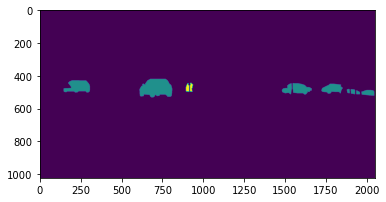

In [59]:
plt.imshow(msk.cpu().detach().numpy())

In [48]:
# this must point to an instance mask, e.g. aachen_000096_000019_gtFine_instanceIds.png
# this will return a full image mask with all non-selected classes=0
# for mask prediction you should add the code here that identifies classes of objects
# you can add code here to extract bboxes
def extract_instance_mask_cityscapes(fname, list_of_predicted_labels):
    mask = torch.tensor(np.array(Image.open(fname)), dtype=torch.uint8)
    # get segmentation mask to find which classes to get rid of
    _fname_segment = re.sub('instanceIds', 'labelIds', fname)
    _mask_segmentation = extract_segmentation_mask_cityscapes(_fname_segment, list_of_predicted_labels)
    # get rid of all instances except the predicted
    mask_instances_bgr = mask*_mask_segmentation
    _instances = np.unique(mask_instances_bgr)
    list_of_masks = []
    for  _m in _instances[1:]:
         _mask = torch.zeros(mask.shape, dtype = torch.uint8)
         _mask[mask_instances_bgr == _m] = 1
         plt.imshow(_mask)
         plt.show()    
         list_of_masks.append(_mask)

    return list_of_masks


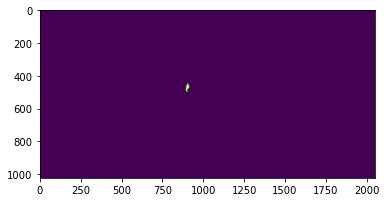

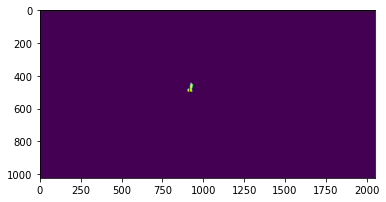

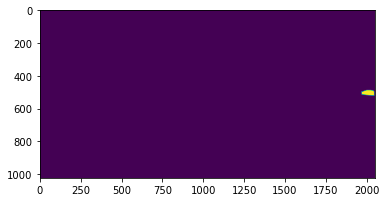

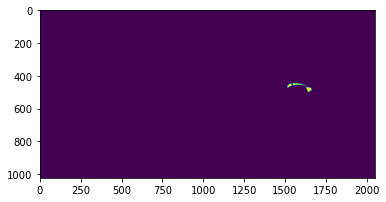

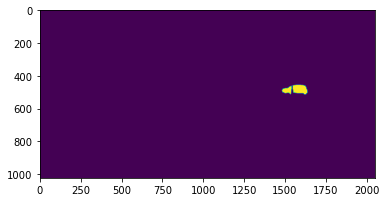

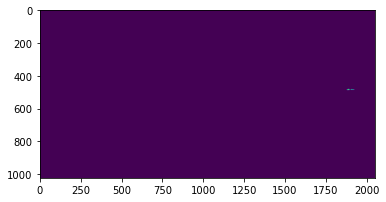

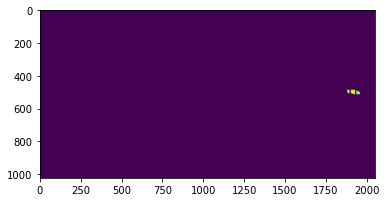

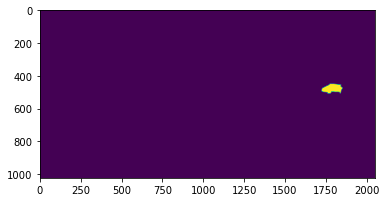

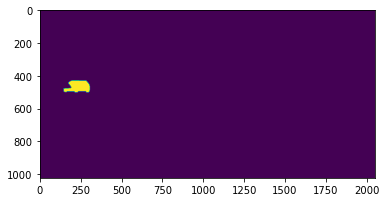

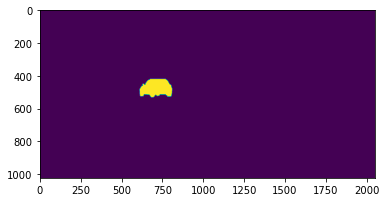

In [60]:
masks = extract_instance_mask_cityscapes(path+"aachen_000000_000019_gtFine_instanceIds.png", list_of_predicted_classes)

In [61]:
len(masks)

10

In [62]:
for mask in masks:
    print(mask.shape)

torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])


In [63]:
masks[0].cpu().detach().numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [64]:
masks[0].cpu().detach().numpy().shape

(1024, 2048)

In [99]:
img = Image.open(path+'aachen_000001_000019_gtFine_color.png')

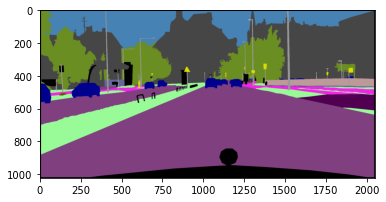

In [100]:
plt.imshow(img)

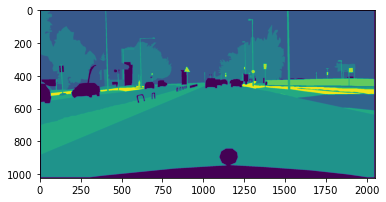

In [104]:
plt.imshow(np.array(img)[:,:,0])

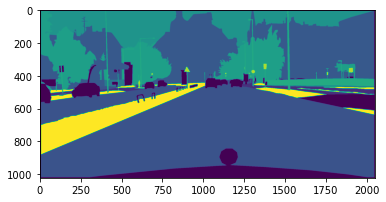

In [106]:
plt.imshow(np.array(img)[:,:,1])

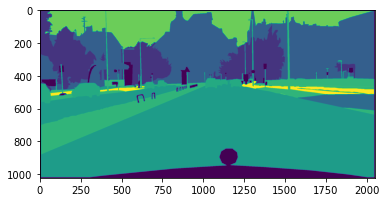

In [108]:
plt.imshow(np.array(img)[:,:,2])

In [113]:
np.squeeze(np.array(img), axis=0).shape

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [114]:
img_np = np.array(img)

In [117]:
result = img_np[:,:, :3]

In [118]:
result.shape

(1024, 2048, 3)

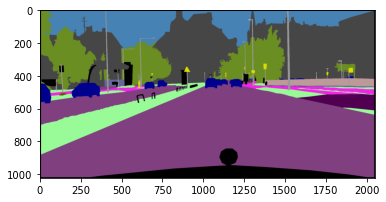

In [119]:
plt.imshow(result)

In [107]:
np.unique(np.array(img)[:,:,3])

array([255], dtype=uint8)

In [82]:
np.unique(np.array(img))

array([    0,     1,     3,     4,     7,     8,    11,    17,    20,
          21,    22,    23, 24000, 24001, 25000, 26003, 26004, 26005,
       26006, 26007, 26008, 26009, 26010, 33000, 33001])

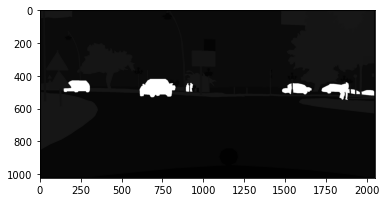

In [79]:
plt.imshow(img)

In [122]:
p = '../../Datasets/Pascal voc 2012/VOC2012 trainval/SegmentationObject/2007_000032.png'

In [123]:
img = Image.open(p)

In [125]:
np.array(img).shape

(281, 500)

In [127]:
uniques = np.unique(np.array(img))

In [130]:
np_img = np.array(img)

In [141]:
list_masks = []
for u in uniques:
    
    if u != 255 and u != 0:
        #print(u)
        np_img_copy = np_img.copy()
        #print(np.unique(np_img_copy))
        np_img_copy[np_img_copy == u] = u
        #print(np.unique(np_img_copy))
        np_img_copy[np_img_copy != u] = 0
        #print(np.unique(np_img_copy))
        list_masks.append(np_img_copy)
        print(len(list_masks))

1
2
3
4


In [143]:
for m in list_masks:
    print(np.unique(m))

[0 1]
[0 2]
[0 3]
[0 4]


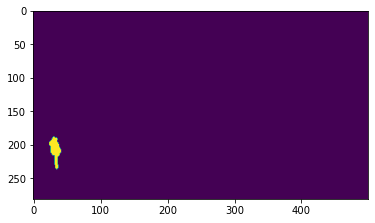

In [148]:
plt.imshow(list_masks[3])

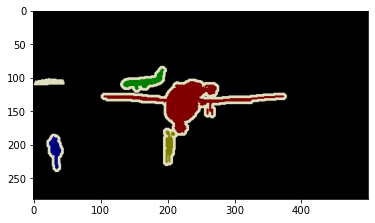

In [124]:
plt.imshow(img)

In [152]:
img = Image.open('../../Datasets/CityScapes/gtCoarse/gtCoarse/train/aachen' + '/aachen_000000_000019_gtCoarse_color.png')

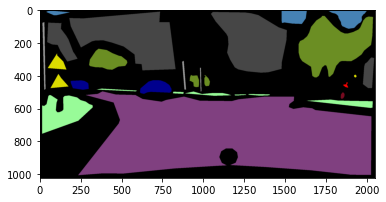

In [153]:
plt.imshow(img)

In [155]:
np.array(img).shape

(1024, 2048, 4)

In [156]:
img_np = np.array(img)[:,:,:3]

In [168]:
idx = 1000
idx2 = 700 

In [172]:
img_np[idx2,idx,0]

128

In [173]:
img_np[idx2,idx,1]

64

In [174]:
img_np[idx2,idx,2]

128